# PyNeuroGLM Tutorial

This tutorial demonstrates the complete workflow of using PyNeuroGLM for neural data analysis:
- Loading experimental data
- Setting up experiments and trials
- Building design matrices with various covariates
- Fitting GLMs using both Bayesian and scikit-learn approaches
- Visualizing results

## Imports

In [24]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from pymatreader import read_mat
from sklearn.linear_model import PoissonRegressor

from pyneuroglm import basis
from pyneuroglm.experiment import Experiment, Trial
from pyneuroglm.design import DesignMatrix
from pyneuroglm.regression import prior
from pyneuroglm.regression.posterior import get_posterior_weights

## Helper Functions

In [25]:
def print_sparse(x):
    """Helper function to print sparse matrices for debugging"""
    from scipy.sparse import coo_matrix

    if x.ndim == 1:
        x = np.expand_dims(x, -1)
    print(coo_matrix(x))

## Load Data

Load the example MATLAB data file containing neural and behavioral data.

In [26]:
this_dir = Path(".")  # Current directory
matfile = read_mat(this_dir / "exampleData.mat")

nTrials = matfile["nTrials"]
param = matfile["param"]
trials = matfile["trial"]

print(f"Number of trials: {nTrials}")
print(f"Parameters keys: {param.keys() if hasattr(param, 'keys') else type(param)}")
print(f"Trials keys: {trials.keys() if hasattr(trials, 'keys') else type(trials)}")

Number of trials: 100
Parameters keys: dict_keys(['samplingFreq', 'monkey'])
Trials keys: dict_keys(['duration', 'LFP', 'eyepos', 'dotson', 'dotsoff', 'saccade', 'coh', 'choice', 'sptrain', 'sptrain2', 'meta'])


## Experiment Setup

Define the experimental parameters and register all the different types of data we'll be working with.

In [ ]:
unit_of_time = "ms"  # "ms" or "s"
binsize = 1  # 1ms
time_scale = 1

# Set up experiment
expt = Experiment(unit_of_time, binsize, "", param)

# Register different types of variables
expt.register_continuous("LFP", "Local Field Potential", 1)
expt.register_continuous("eyepos", "Eye Position", 2)
expt.register_timing("dotson", "Motion Dots Onset")  # timing variables are for events
expt.register_timing("dotsoff", "Motion Dots Offset")
expt.register_timing("saccade", "Saccade Time")
expt.register_spike_train("sptrain", "Our Neuron")
expt.register_spike_train("sptrain2", "Neighbor Neuron")
expt.register_value("coh", "Coherence")  # trialwise info
expt.register_value("choice", "Direction of Choice")

## Add Trials to Experiment

Load the trial data into the experiment object.

In [28]:
for k in range(nTrials):
    trial = Trial(k, trials["duration"][k] * time_scale)
    trial["LFP"] = trials["LFP"][k]
    trial["eyepos"] = trials["eyepos"][k]
    trial["dotson"] = trials["dotson"][k] * time_scale
    trial["dotsoff"] = trials["dotsoff"][k] * time_scale
    trial["saccade"] = trials["saccade"][k] * time_scale
    trial["coh"] = trials["coh"][k]
    trial["choice"] = trials["choice"][k]
    trial["sptrain"] = trials["sptrain"][k] * time_scale
    trial["sptrain2"] = trials["sptrain2"][k] * time_scale

    expt.add_trial(trial)

print(f"Added {len(expt.trials)} trials to experiment")

Added 100 trials to experiment


## Build Design Matrix

Create a design matrix with various types of covariates.

In [ ]:
dm = DesignMatrix(experiment=expt)
binfun = expt.binfun

Adding covariates to design matrix...


### Add LFP Covariate
Local field potential with a smooth temporal basis.

In [ ]:
# Example improvement for basis functions
bs = basis.make_smooth_temporal_basis(
    "boxcar", 
    duration=100 * time_scale,  # 100ms window
    n_bases=10,                 # 10 basis functions for smooth representation
    binfun=binfun
)
bs.B = 0.1 * bs.B
dm.add_covariate_raw("LFP", basis=bs)

Added LFP covariate


### Add Spike Train Covariates
History filter and coupling from another neuron.

In [ ]:
dm.add_covariate_spike("hist", "sptrain", "History filter")
dm.add_covariate_spike("coupling", "sptrain2", "Coupling from neuron 2")

Added spike train covariates


### Add Motion Dots Stimulus

In [ ]:
dm.add_covariate_boxcar("dots", "dotson", "dotsoff", "Motion dots stim")

Added motion dots stimulus covariate


### Add Saccade Timing (Acausal)
This represents the relationship where spikes might precede saccades.

In [ ]:
bs = basis.make_smooth_temporal_basis("boxcar", 300 * time_scale, 8, binfun)
offset = -200 * time_scale
dm.add_covariate_timing("saccade", basis=bs, offset=offset)

Added saccade timing covariate


### Add Coherence-Dependent Kernel
A custom covariate that depends on trial coherence.

In [ ]:
bs = basis.make_smooth_temporal_basis("raised cosine", 200 * time_scale, 10, binfun)

def stim_handle(t):
    return t["coh"] * basis.boxcar_stim(
        binfun(t["dotson"]), binfun(t["dotsoff"], True), binfun(t.duration, True)
    )

dm.add_covariate("cohKer", "coh-dep dots stimulus", stim_handle, bs)

Added coherence-dependent kernel


### Add Eye Position Covariate

In [ ]:
bs = basis.make_smooth_temporal_basis("raised cosine", 40 * time_scale, 4, binfun)
dm.add_covariate_raw("eyepos", basis=bs)
print(f"Total covariates: {len(dm.covariates)}")

Added eye position covariate
Total covariates: 7


## Compile Design Matrix

Compile the design matrix for a subset of trials and normalize for visualization.

In [ ]:
trial_indices = np.arange(10)
dm.compile_design_matrix(trial_indices)

end_trial_indices = np.cumsum(
    [binfun(trial.duration, True) for trial in expt.trials.values()]
)
X = dm.X[: end_trial_indices[2]]
mv = np.max(np.abs(X), 0, keepdims=True)
mv[np.isnan(mv)] = 1
X = X / (mv + 1e-20)

Design matrix shape: (2269, 57)
Visualization subset shape: (723, 57)


## Visualize Design Matrix

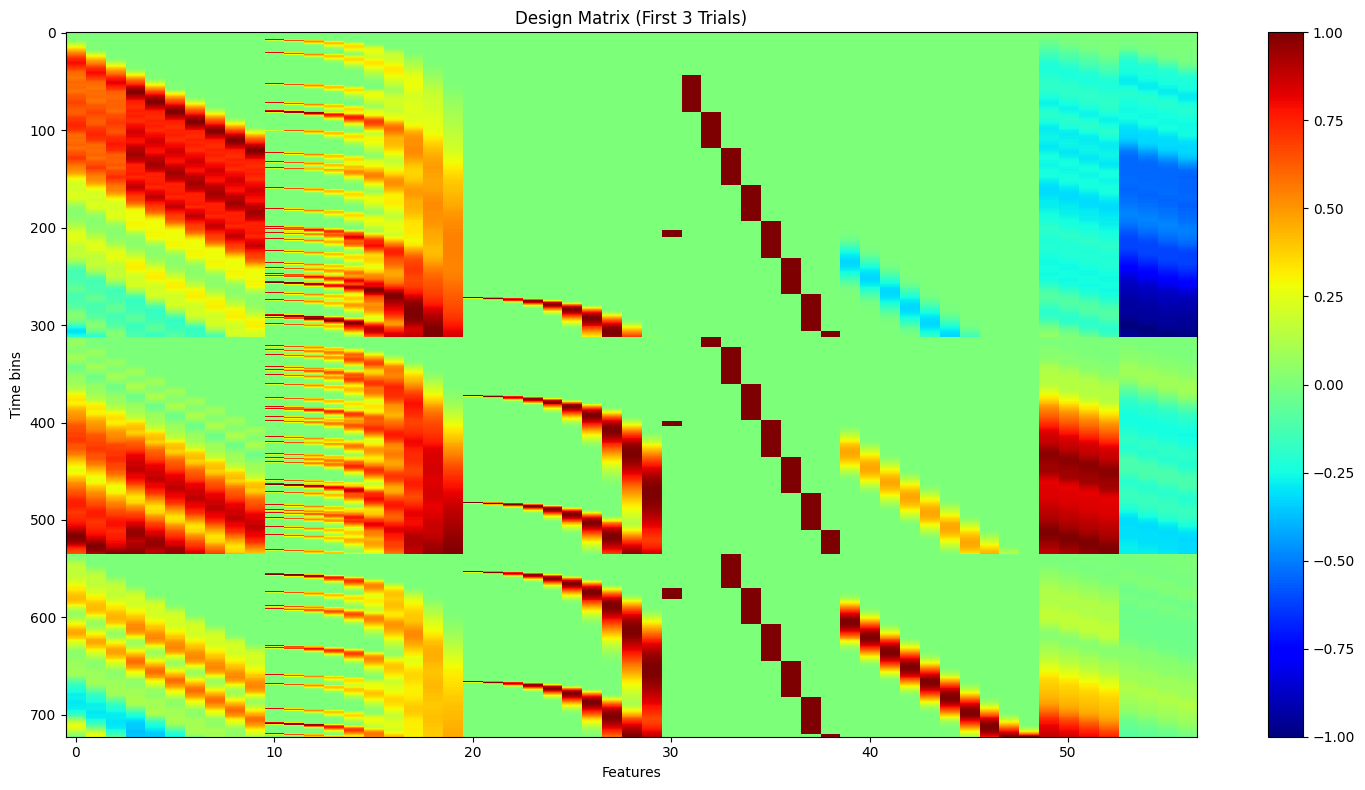

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(X, aspect="auto", cmap="jet", interpolation="none")
ax.set_title("Design Matrix (First 3 Trials)")
ax.set_xlabel("Features")
ax.set_ylabel("Time bins")
plt.colorbar(im)
plt.tight_layout()
plt.show()

## Get Spike Train Data

Extract the binned spike counts for the target neuron.

In [38]:
y = dm.get_binned_spike("sptrain", trial_indices)
print(f"Spike train shape: {y.shape}")
print(f"Total spikes: {np.sum(y)}")
print(f"Mean firing rate: {np.mean(y):.4f} spikes/bin")
assert len(dm.X) == len(y)

Spike train shape: (2269,)
Total spikes: 214.0
Mean firing rate: 0.0943 spikes/bin


## Preprocess Design Matrix

Z-score specific columns and verify compatibility with MATLAB version.

In [ ]:
# Z-score the LFP columns
col_inds = dm.get_design_matrix_col_indices("LFP")
dm.zscore_columns(col_inds)
X = dm.X

# Verify compatibility with MATLAB version
try:
    matfile = read_mat(this_dir / "exampleDM.mat")
    matX = matfile["Z"]
    is_close = np.allclose(matX, X)
    print(f"Design matrix matches MATLAB version: {is_close}")
except FileNotFoundError:
    print("MATLAB comparison file not found, skipping compatibility check")

Z-scored 10 LFP columns
Design matrix matches MATLAB version: True


## Fit GLM using Bayesian Approach

Use the posterior weight estimation with ridge regularization.

In [ ]:
n, m = dm.X.shape
X_with_intercept = np.column_stack((np.ones(n), dm.X))
w, sd, _ = get_posterior_weights(
    X_with_intercept, y, prior.ridge_Cinv(50, m, True), init_kwargs={"nlin": np.log}
)

intercept = w[0]
w = w[1:]  # Remove intercept
weights_bayesian = dm.combine_weights(w)

print("Bayesian GLM fit complete")
print(f"Intercept: {intercept:.4f}")
print(f"Number of weight components: {len(weights_bayesian)}")

Bayesian GLM fit complete
Intercept: -2.3620
Number of weight components: 7


## Fit GLM using scikit-learn

Compare with a standard Poisson regression implementation.

In [ ]:
poisreg = PoissonRegressor(alpha=50., solver="newton-cholesky").fit(dm.X, y)
w_sk = poisreg.coef_
weights_sklearn = dm.combine_weights(w_sk)

print("Scikit-learn GLM fit complete")
print(f"Sklearn intercept: {poisreg.intercept_:.4f}")
print(f"Number of weight components: {len(weights_sklearn)}")

Scikit-learn GLM fit complete
Sklearn intercept: -2.3891
Number of weight components: 7


## Visualize GLM Weights

Compare the fitted weights from both approaches.

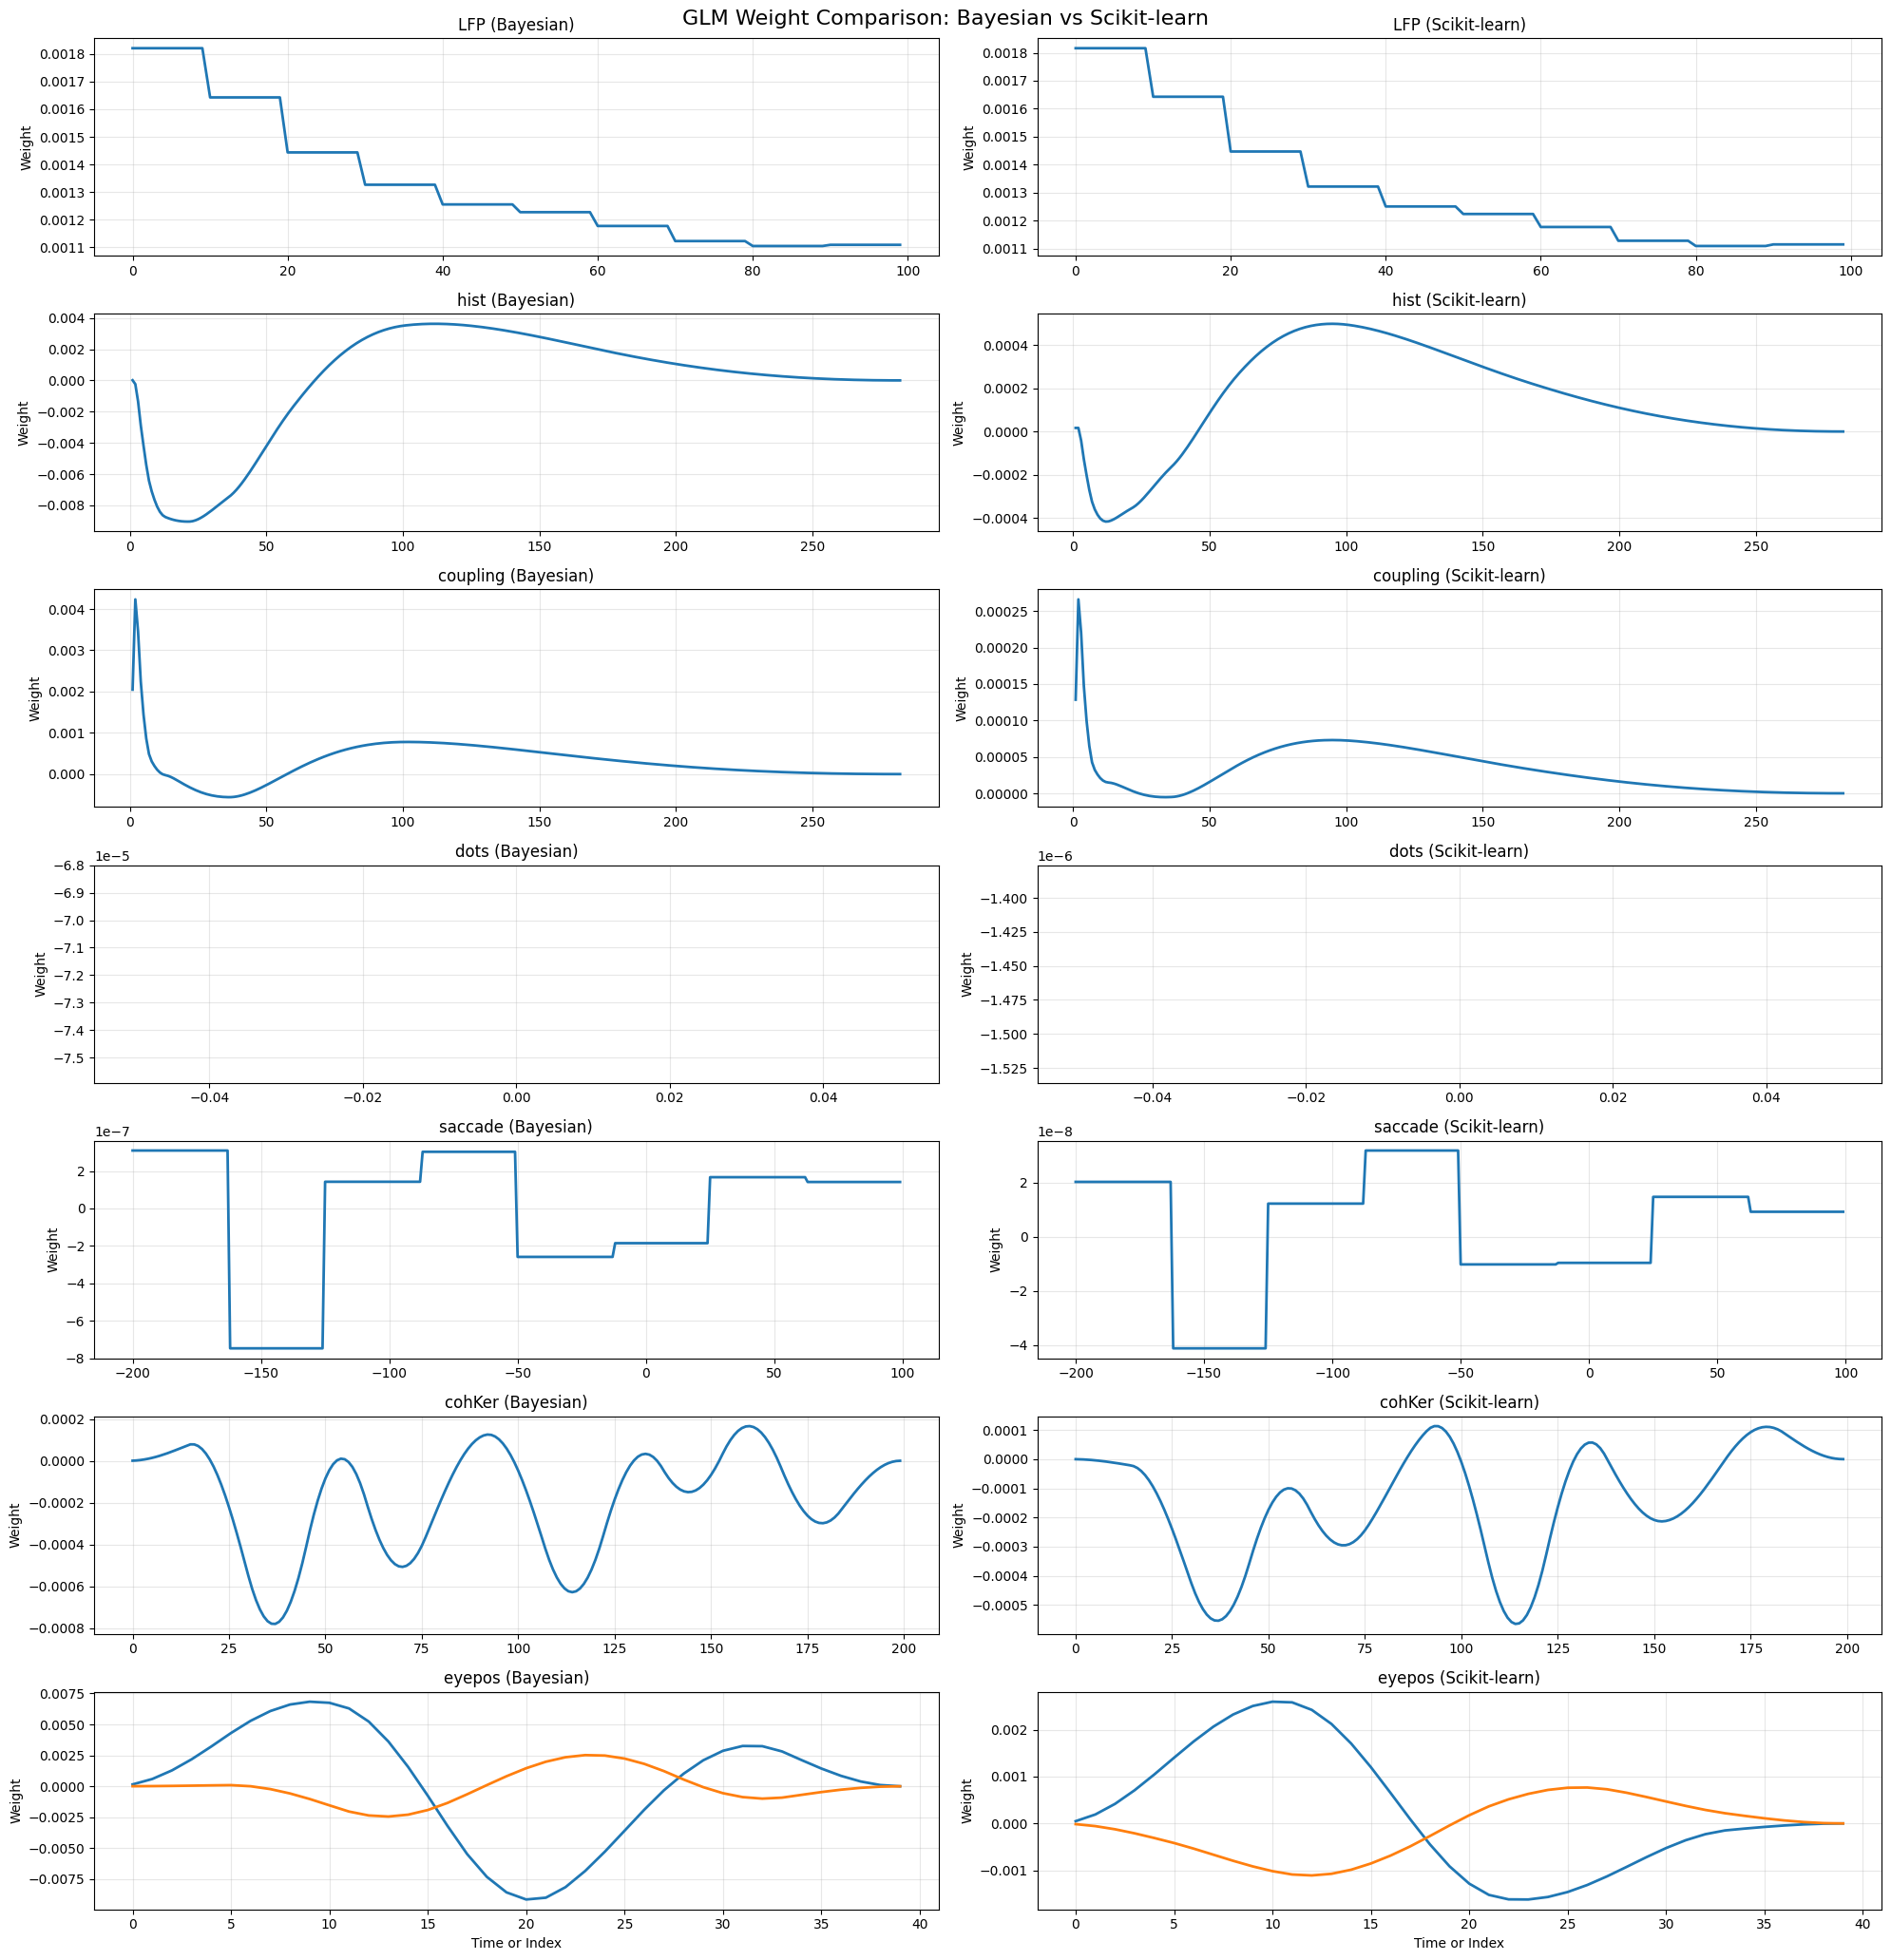

In [42]:
n_covars = len(dm.covariates)
fig, axs = plt.subplots(n_covars, 2, figsize=(20, 3 * n_covars))

# Plot Bayesian weights
for k, (lk, wk) in enumerate(weights_bayesian.items()):
    ax = axs[k, 0]
    ax.plot(wk["tr"], wk["data"], linewidth=2)
    ax.set_title(f"{lk} (Bayesian)")
    ax.grid(True, alpha=0.3)
    if k == n_covars - 1:
        ax.set_xlabel("Time or Index")
    ax.set_ylabel("Weight")

# Plot sklearn weights
for k, (lk, wk) in enumerate(weights_sklearn.items()):
    ax = axs[k, 1]
    ax.plot(wk["tr"], wk["data"], linewidth=2)
    ax.set_title(f"{lk} (Scikit-learn)")
    ax.grid(True, alpha=0.3)
    if k == n_covars - 1:
        ax.set_xlabel("Time or Index")
    ax.set_ylabel("Weight")

fig.suptitle("GLM Weight Comparison: Bayesian vs Scikit-learn", fontsize=16)
fig.tight_layout()
plt.show()

## Summary

This tutorial demonstrated the complete PyNeuroGLM workflow:

1. **Data Loading**: Imported experimental data from MATLAB format
2. **Experiment Setup**: Registered different types of neural and behavioral variables
3. **Trial Management**: Added trial data to the experiment object
4. **Design Matrix Construction**: Built a comprehensive design matrix with multiple covariate types:
   - LFP (continuous neural signal)
   - Spike history and coupling
   - Stimulus timing (motion dots)
   - Behavioral events (saccades)
   - Trial-dependent kernels (coherence)
   - Eye position
5. **Model Fitting**: Compared Bayesian and frequentist GLM approaches
6. **Visualization**: Examined the fitted weights for each covariate

The weights reveal how each covariate influences neural firing, providing insights into the neural computations underlying behavior.